# Programmierübung 3: Steuerung und Regelung
Version 1.2.0

### Vorbereitung
Bitte installiere zunächst die benötigten Bibliotheken für diese Programmierübung. 
Dies kannst du tun, indem du mit deinem Terminal zunächst in das (entpackte) Verzeichnis dieser Programmierübung navigierst.
Dort solltest du neben diesem Notebook auch ein Verzeichnis "cer_pex3_lib" sehen.
Installiere dieses mittels
```bash
pip install ./cer_pex3_lib
```
Bei der Installation dieses Pakets werden alle in dieser Übung benötigten Pakete automatisch mitinstalliert.

### Module importieren
Hier importieren wir die benötigten Module für diese Programmierübung.
Bitte importiere keine weiteren Module, die hier aufgeführten sind ausreichend um die Aufgabe zu bearbeiten.

In [30]:
%matplotlib notebook
import time
from typing import Tuple, List, Sequence, Callable, Iterable
import numpy as np
from abc import ABC, abstractmethod

import matplotlib

matplotlib.use("nbAgg")
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.axis import Axis

try:
    from cer_pex3 import RobotArm, test_almost_zero, test_geq, test_true, check_shape, TargetSpecifications, \
        target_specs_pd, target_specs_pid, get_letter_print_path, traj_gen_tests_1d, traj_gen_tests_2d, \
        traj_trans_tests
except ImportError:
    print(
        "I did not find the cer_pex3 library. Please make sure you installed it via \"pip install /path/to/cer_pex3_lib\".")
    raise
    
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.max_open_warning"] = 99

### Visualisierung aufsetzen
Mit dieser Funktion erzeugen wir die Roboterarme mitsamt ihrer Matplotlib Axen, auf denen wir die Roboter rendern. Du kannst gerne an den Einstellungen hier herumspielen, um die Visualisierung besser an deine Bedürfnisse anzupassen. Bitte ändere jedoch nicht die Parameter des Roboterarms.

In [31]:
def setup_arms(count: int, l: Iterable[float], m: Iterable[float], gravity: float = 9.81) \
        -> Tuple[plt.Figure, Sequence[Axis]]:
    # Feel free to adapt these settings to better match your liking
    grid_size = (2, 3)

    arms = []

    # Initialize all arms
    for i in range(count):
        fig = plt.figure(figsize=[9.8, 4])
        fig.tight_layout()
        fig.suptitle("Arm {}".format(i))
        
        # Setup axes for visualization
        ax_arm = plt.subplot2grid(grid_size, (0, 0), rowspan=2)
        ax_pos1 = plt.subplot2grid(grid_size, (0, 1))
        ax_pos2 = plt.subplot2grid(grid_size, (1, 1))
        ax_vel1 = plt.subplot2grid(grid_size, (0, 2))
        ax_vel2 = plt.subplot2grid(grid_size, (1, 2))
    
        # Do not change the parameters of the robot arm!
        arm = RobotArm(l, m, fig, ax_arm, ax_pos1, ax_pos2, ax_vel1, ax_vel2, gravity)

        ax_arm.set_xlim(-1.7, 1.7)
        ax_arm.set_ylim(-1.7, 1.7)
        ax_arm.set_aspect("equal")
        ax_arm.xaxis.set_major_locator(MultipleLocator(0.4))
        ax_arm.yaxis.set_major_locator(MultipleLocator(0.4))
        ax_arm.xaxis.set_minor_locator(MultipleLocator(0.2))
        ax_arm.yaxis.set_minor_locator(MultipleLocator(0.2))
        ax_arm.set_xlabel("x")
        ax_arm.set_ylabel("y")
        ax_arm.yaxis.set_label_coords(-0.15, 0.5)
        ax_arm.grid()
        ax_arm.grid(which="minor")

        for ax in [ax_pos1, ax_pos2, ax_vel1, ax_vel2]:
            ax.set_xlabel("t")
        for j, ax in enumerate([ax_pos1, ax_pos2]):
            ax.set_ylabel("q_{}".format(j + 1))
        for j, ax in enumerate([ax_vel1, ax_vel2]):
            ax.set_ylabel("dq_{}".format(j + 1))
        
        arm.render()

        arms.append(arm)
    return arms

### Basisklasse für Regler

In [32]:
class Controller(ABC):
    """
    Abstract base class for controllers.
    """
    @abstractmethod
    def __call__(self, q: np.ndarray, dq: np.ndarray, q_target: np.ndarray, dq_target: np.ndarray, dt: float) \
            -> np.ndarray:
        """
        Computes new torques given the system state and target state.
        :param q:         A 2D numpy array containing the current joint positions.
        :param dq:        A 2D numpy array containing the current joint velocities.
        :param q_target:  A 2D numpy array containing the target joint positions.
        :param dq_target: A 2D numpy array containing the target joint velocities.
        :param dt:        The time step of the system as float.
        :return: A 2D numpy array containing the torques for the two joints.
        """
        pass
    
    def reset(self):
        """
        Resets the controller to the initial state.
        """
        pass

### Testfunktion für Regler
Hier gibt es nichts zu tun. Mit dieser Funktion testen wir die von euch implementierten Regler.

In [33]:
def test_controller(controller: Controller, target_specs: List[TargetSpecifications], gravity: float = 9.81, 
                    test: bool = True):
    # Visualization settings
    fps = 2  # If the visualization is slowing down too much, try reducing this value, default: 10
    real_time_factor = 2  # Increase/decrease this value to speed up/slow down the simulation, default: 0.5

    arms = setup_arms(len(target_specs), (0.8, 0.8), (1.0, 1.0), gravity=gravity)
    
    type_str = "Test" if test else "Example"
    for i, arm in enumerate(arms):
        arm.fig.suptitle("{} {} (pending)".format(type_str, i))
        arm.render()
    
    for i, (arm, tar) in enumerate(zip(arms, target_specs)):
        arm.set_target_traj(tar.q_tar, tar.dq_tar, tar.q_error_bounds, tar.dq_error_bounds)
        arm.reset(tar.init_q, tar.init_dq)
        arm.start_drawing()
        controller.reset()

        failed = False
        last_rendering = time.time()
        render_interval = int(real_time_factor / (fps * arm.dt))
        for t, (q_tar, dq_tar, q_bounds, dq_bounds) in enumerate(zip(
                tar.q_tar, tar.dq_tar, tar.q_error_bounds, tar.dq_error_bounds)):
            torques = controller(arm.q, arm.dq, q_tar, dq_tar, arm.dt)
            arm.step_simulator(torques)
            
            if not failed:
                q_ok = np.all((q_bounds[:, 0] <= arm.q - q_tar) & (arm.q - q_tar <= q_bounds[:, 1]))
                dq_ok = np.all((dq_bounds[:, 0] <= arm.dq - dq_tar) & (arm.dq - dq_tar <= dq_bounds[:, 1]))

                if not q_ok:
                    arm.fig.suptitle(
                        "{} {} (failed, q out of bounds at t={:0.3f})".format(type_str, i, t * arm.dt), 
                        color="red")
                    failed = True
                elif not dq_ok:
                    arm.fig.suptitle(
                        "{} {} (failed, dq out of bounds at t={:0.3f})".format(type_str, i, t * arm.dt), 
                        color="red")
                    failed = True
            
            if t % render_interval == 0:
                arm.render()
                now = time.time()
                wait_time = last_rendering + arm.dt * render_interval / real_time_factor - now
                time.sleep(max(0.0, wait_time))
                last_rendering = time.time()
        if not failed:
            arm.fig.suptitle("{} {} (passed)".format(type_str, i, t), color="green")
        arm.render()


## 1. Implementierung eines PD-Reglers

In [5]:
class PDController(Controller):
    """
    Implements a PD controller.
    """
    
    def __init__(self, p: np.ndarray, d: np.ndarray):
        """
        :param p: A 2D numpy array containing the p parameters of the PD controller for each joint.
        :param d: A 2D numpy array containing the d parameters of the PD controller for each joint.
        """
        self.p = p
        self.d = d
    
    def __call__(self, q: np.ndarray, dq: np.ndarray, q_target: np.ndarray, dq_target: np.ndarray, dt: float) \
            -> np.ndarray:
        """
        Computes new torques given the system state and target state.
        :param q:         A 2D numpy array containing the current joint positions.
        :param dq:        A 2D numpy array containing the current joint velocities.
        :param q_target:  A 2D numpy array containing the target joint positions.
        :param dq_target: A 2D numpy array containing the target joint velocities.
        :param dt:        The time step of the system as float.
        :return: A 2D numpy array containing the torques for the two joints.
        """
        # Implement this...
        return self.p *(q_target - q) + self.d *(dq_target -dq)


### Öffentliche Tests

In [6]:
test_cases = [
    (([1.0, 5.0],    [5.0, 1.0],     [0.5, 1.0],   [0.0, 0.0],    [0.7, 1.2],   [0.1, 0.5]),    [0.7, 1.5]),
    (([10.0, 1.5],   [100.0, 200.0], [0.3, -1.0],  [0.1, 0.7],    [-0.7, -1.2], [0.0, 0.0]),    [-20.0, -140.3]),
    (([40.0, 60.0],  [1.0, 60.0],    [0.5, 1.0],   [10.0, 0.7],   [15.0, 12.5], [15.0, -15.0]), [585.0, -252.0]),
    (([32.4, 70.0],  [13.0, 15.0],   [-0.4, -2.0], [50.0, -0.8],  [1.4, 1.8],   [-0.17, 0.76]), [-593.89, 289.4]),
    (([123.0, 25.0], [50.0, 9.0],    [-0.5, 1.7],  [-25.0, 60.0], [2.0, -0.9],  [20.0, -0.5]),  [2557.5, -609.5]),
    (([12.0, 42.0],  [0.0, 0.0],     [0.6, -1.9],  [40.0, -13.0], [-1.5, -3.0], [-34.5, 17.4]), [-25.2, -46.2])]
dt = 0.001

for i, ((p, d, q, dq, q_tar, dq_tar), torques_tar) in enumerate(test_cases):
    controller = PDController(p, d)
    torques = controller(np.array(q), np.array(dq), np.array(q_tar), np.array(dq_tar), dt)
    test_almost_zero(i, np.linalg.norm(torques - torques_tar))

Test 0: passed.
Test 1: passed.
Test 2: passed.
Test 3: passed.
Test 4: passed.
Test 5: passed.


## 2. Einstellen der Parameter des PD-Reglers

In [7]:
def get_pd_controller_coefficients() -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns your optimized PD controller coefficients.
    :return: A tuple of two 2D numpy arrays, where the first array contains the p coefficients for each joint and
             the second array contains the d coefficients for each joint.
    """
    # Implement this...
    """
    Hier soll man einfach nur raten ..... Danke für die tolle Aufgabenstellung!!! Schön, dass man 3 Stunden Lebenszeit damit versucht die Aufgabe zu lösen, bis man im Forum eine Aussage dazu findet, die das klarstellt ...
    Viele VIELE MESSUNGEN !!!!
    P=(450,450), D=(50,50) funktioniert
    """
    p = np.array([450,450])
    d = np.array([50,50])
    return p, d


### Öffentliche Tests
Stelle sicher, dass die Trajektorie der Gelenkwinkel und -geschwindigkeiten den roten Bereich bei der Regelung nicht verlässt.

<IPython.core.display.Javascript object>


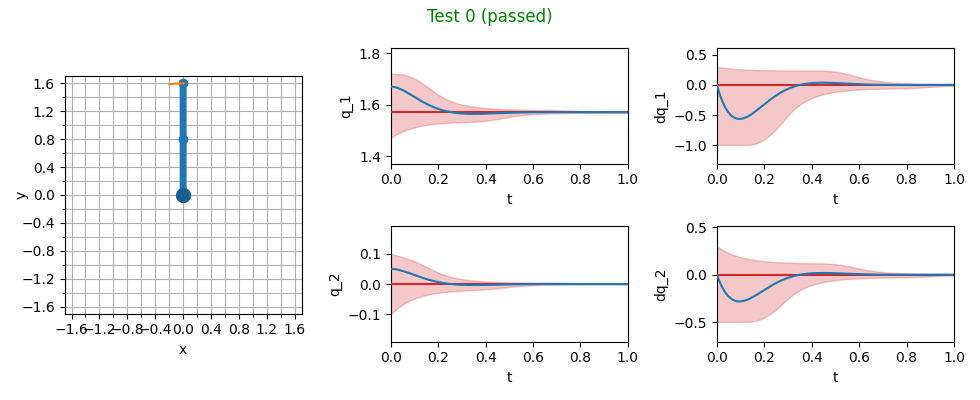

<IPython.core.display.Javascript object>


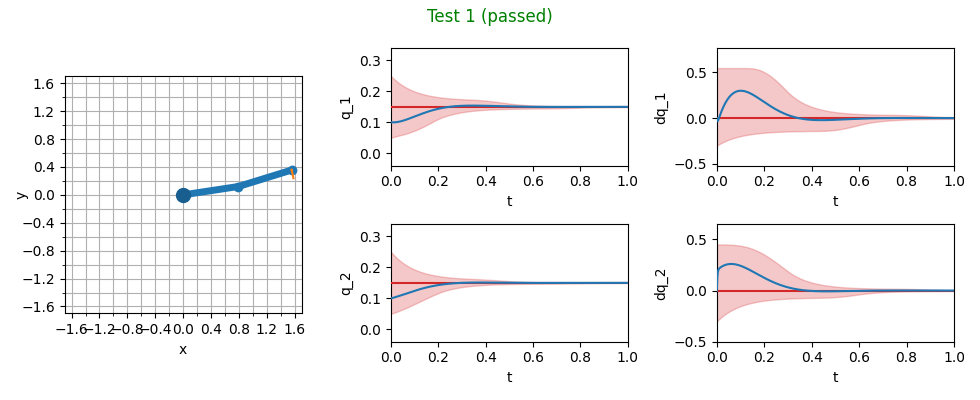

<IPython.core.display.Javascript object>


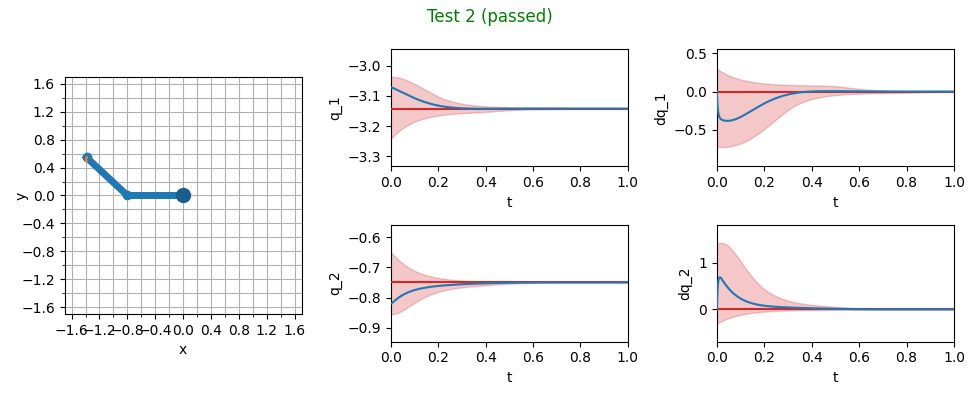

<IPython.core.display.Javascript object>


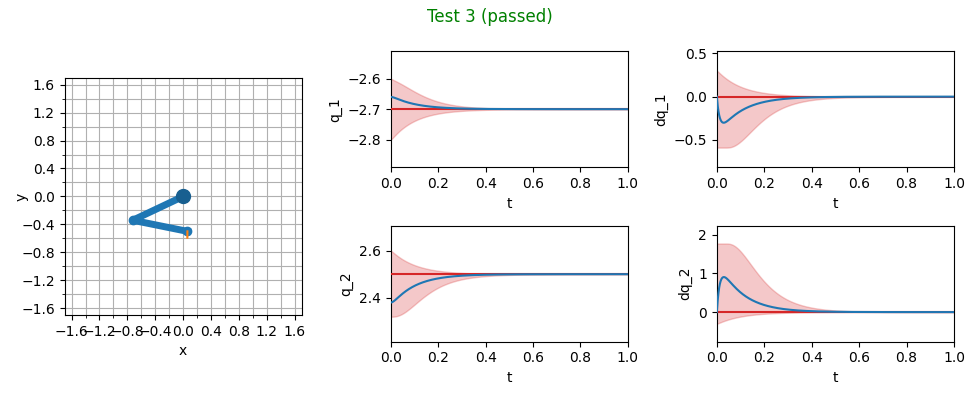

<IPython.core.display.Javascript object>


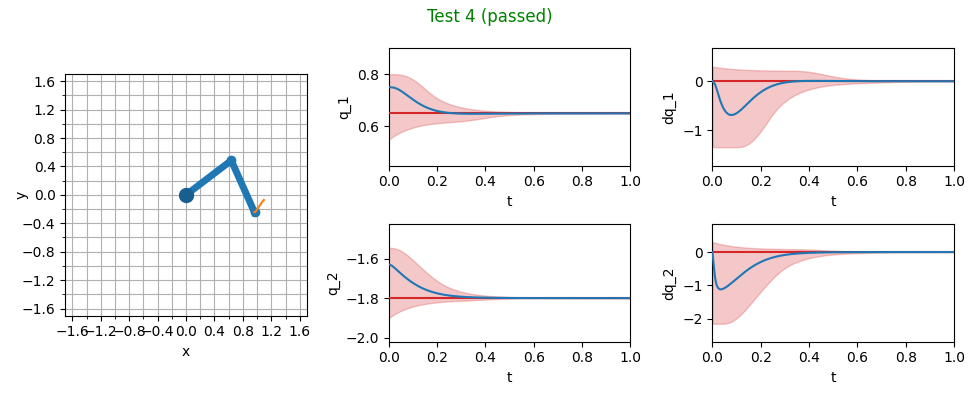

<IPython.core.display.Javascript object>


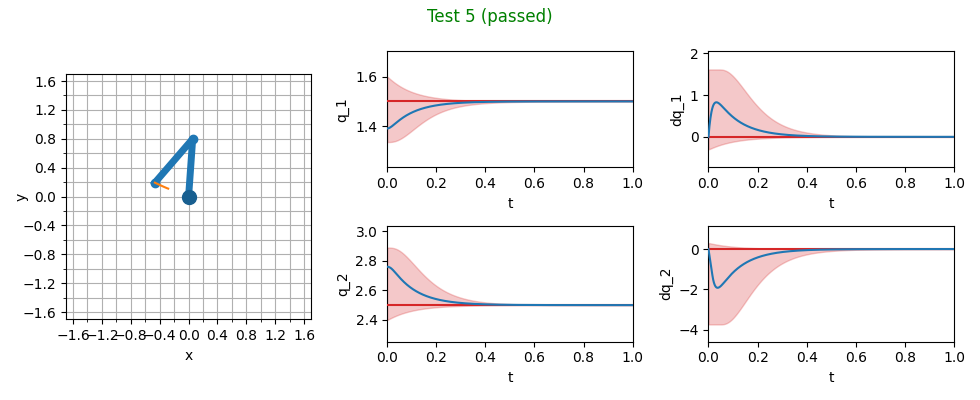

In [8]:
# Call your function to get the PD coefficients
p, d = get_pd_controller_coefficients()

check_shape(p, (2,), "p")
check_shape(d, (2,), "d")

# Create the controller
controller = PDController(p, d)

# Run the controller through a bunch of tests without gravity
test_controller(controller, target_specs_pd, gravity=0.0)

### Sind wir fertig?
**Wichtig:** die folgenden Beispiele sind keine Tests, sondern sollen lediglich die Limitationen des PD Reglers offenlegen.

<IPython.core.display.Javascript object>


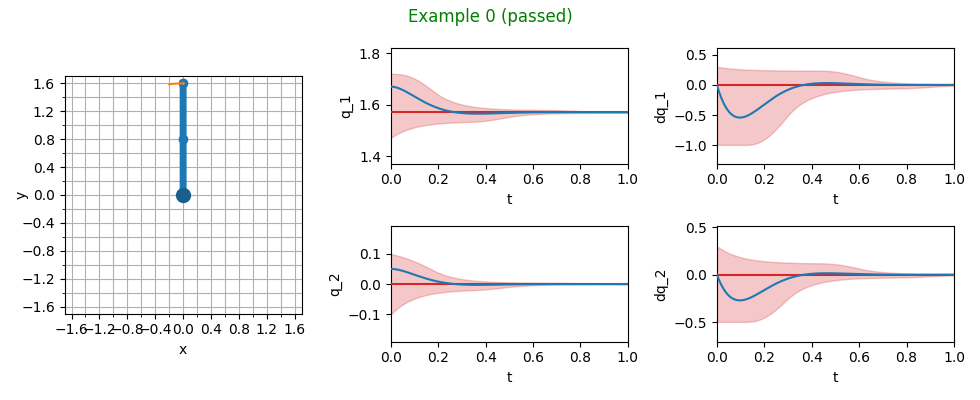

<IPython.core.display.Javascript object>


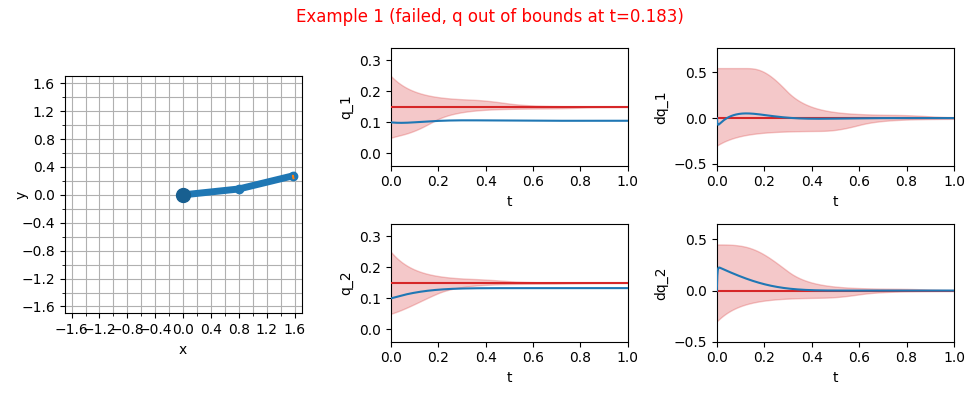

<IPython.core.display.Javascript object>


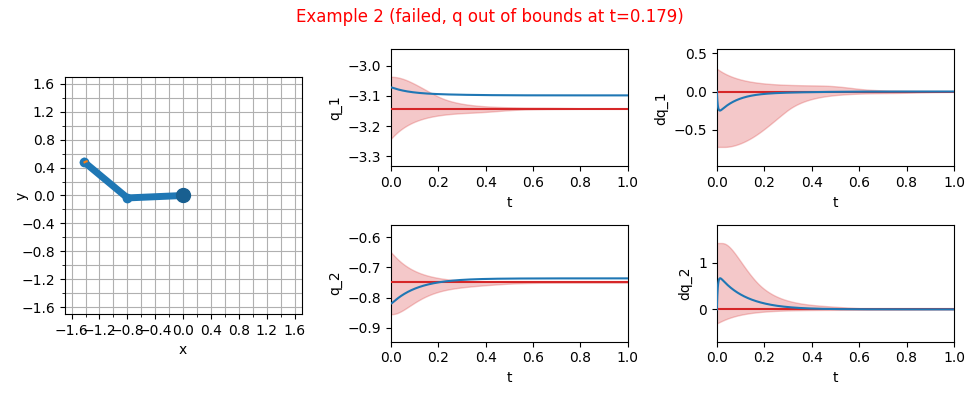

In [9]:
p, d = get_pd_controller_coefficients()
controller = PDController(p, d)

# Enable gravity this time...
test_controller(controller, target_specs_pd[:3], gravity=9.81, test=False)

Simulieren wir Gravitation, so sehen wir, dass unser Regler außerhalb von Ruhelagen nicht in der Lage ist, die Zielposition zu erreichen. Das Problem ist, dass durch die Gravitation eine konstante Kraft auf unser System wirkt, die sich mit den von unserem Regler erzeugten Steuersignalen irgendwo in der Nähe der Zielposition ausbalanciert. Um dieses Problem zu lösen, müssen wir unseren Regler so modifizieren, dass dieser in solchen Situtationen zusätzliches Drehmoment aufbringt, um die Zielposition trotz Gravitation zu erreichen. Dies werden wir im Folgenden durch das Einführen eines Integral (I) Anteils tun. Unser Regler wird dadurch von einem PD-Regler zu einem PID-Regler.

## 3. Implementierung eines PID-Reglers

In [155]:
class PIDController(Controller):
    """
    Implements a PID controller.
    """
    
    def __init__(self, p: np.ndarray, i: np.ndarray, d: np.ndarray):
        """
        :param p: A 2D numpy array containing the p parameters of the PD controller for each joint.
        :param i: A 2D numpy array containing the i parameters of the PD controller for each joint.
        :param d: A 2D numpy array containing the d parameters of the PD controller for each joint.
        """
        self.p = p
        self.d = d
        self.i = i
        # Add more fields if you need them
        # Implement this...
        self.integral = np.zeros((2,))

    
    def __call__(self, q: np.ndarray, dq: np.ndarray, q_target: np.ndarray, dq_target: np.ndarray, dt: float) \
            -> np.ndarray:
        """
        Computes new torques given the system state and target state.
        :param q:         A 2D numpy array containing the current joint positions.
        :param dq:        A 2D numpy array containing the current joint velocities.
        :param q_target:  A 2D numpy array containing the target joint positions.
        :param dq_target: A 2D numpy array containing the target joint velocities.
        :param dt:        The time step of the system as float.
        :return: A 2D numpy array containing the torques for the two joints.
        """
        # Implement this...
        """
        PD : return self.p *(q_target - q) + self.d *(dq_target -dq)
        return self.p *(q_target - q) + self.d *(dq_target -dq) + self.i *(dq_target -dq) * dt ==> Test4 passed

        integral = np.trapz(dq_target-dq, dx=dt)
        res = self.p *(q_target - q) + self.d *(dq_target -dq) + self.i*np.array(integral)
        ==> Ergebnisse sehr(!!) nah aber Integral scheinbar nicht genau genug (auch nicht mit dx = (dt/ 100000000000)
        ==> Schön im Forum zu lesen, dass die Funktion rekursiv aufgerufen wird und hier Rechteck-Integrale erwartet werden ..... Aufgabenstellung mal wieder vollkommen undklar in der Hinsicht und man verschwendet einen Haufen Zeit damit hier Rückwärts zu suchen, was für eine Art der Implementierung erwartet wird ...
        """
        self.integral += (q_target-q) * dt
        return self.p *(q_target - q) + self.d *(dq_target-dq) + self.i * np.array(self.integral)


    def reset(self):
        """
        This function is called at the end of every test and should reset the controller into its initial state.
        """
        # Clean up to prepare this controller for being reused
        # Implement this...
        self.integral = np.zeros((2,))



### Öffentliche Tests

In [156]:
test_cases = [
    (([1.0, 5.0],    [3.0, 2.0],   [5.0, 1.0],     
      [[0.1, -0.1], [0.6, 0.1], [-0.5, 0.4], [1.3, 0.9], [-0.7, -1.3]], 
      [[3.5, 8.2], [3.3, -13.0], [9.1, 4.5], [-5.4, 5.8], [3.6, 2.9]], 
      [[0.2, -0.5], [-0.4, -2.4], [1.8, 1.1], [-0.3, 0.8], [0.3, -0.6]], 
    [[20.4, -25.6], [4.2, -5.7], [-4.5, -2.2], [-20.2, -2.3], [-8.7, 33.2]]), 
     [[84.6003, -35.8008], [3.4973, -5.2058], [-65.6958, -3.2044], [-75.6006, -8.6046], [-60.4976, 33.7968]]),
    
    (([10.0, 1.5],   [7.0, 0.0],   [100.0, 200.0], 
      [[-0.7, -0.2], [1.7, 0.7], [-1.6, 0.0], [-0.6, 0.1], [-1.6, 0.2]], 
      [[-8.0, -13.2], [-2.5, 4.2], [11.4, 1.1], [-5.5, -7.8], [7.5, 16.3]], 
      [[1.1, 1.8], [-2.6, -0.1], [1.0, 1.4], [0.7, 1.5], [0.3, 0.6]], 
      [[0.0, 3.0], [-2.7, -8.9], [-4.5, -9.9], [0.6, 13.4], [-4.9, -6.2]]), 
     [[818.0126, 3243.0], [-63.0175, -2621.2], [-1563.9993, -2197.9], [623.0098, 4242.1], [-1220.9769, -4499.4]]),
    
    (([40.0, 60.0],  [10.0, 60.0], [1.0, 60.0],    
      [[-1.7, -1.3], [-1.4, -0.4], [-2.3, -0.2], [-1.0, 0.9], [1.0, 1.4]], 
      [[-8.0, 2.4], [-16.6, 6.6], [11.4, -4.5], [4.3, 2.5], [-3.9, -8.6]], 
      [[-1.1, -0.7], [-0.8, 0.3], [-0.2, 0.1], [0.8, 0.9], [0.5, -0.5]], 
      [[0.3, 13.6], [12.2, -5.1], [-3.0, -5.3], [5.7, -0.6], [7.5, -18.5]]), 
     [[32.306, 708.036], [52.812, -659.922], [69.633, -29.904], [73.451, -185.904], [-8.554, -708.018]]),
    
    (([32.4, 70.0],  [100.0, 1.7], [13.0, 15.0],   
      [[0.0, 1.0], [0.7, 0.7], [1.6, -1.2], [-0.6, -1.3], [-0.1, 1.0]], 
      [[18.3, -30.8], [9.6, 0.7], [13.2, 3.9], [18.3, 0.3], [-5.2, 5.8]], 
      [[0.7, -1.0], [-1.6, -2.9], [-0.4, 1.2], [0.0, 0.5], [1.0, -0.9]], 
      [[-14.3, -9.4], [3.9, -5.2], [5.3, 8.1], [-14.4, 10.2], [-6.0, 20.9]]), 
     [[-401.05, 180.9966], [-148.78, -340.50952], [-167.86, 230.99456], [-405.96, 274.49762], [25.05, 93.49439]]),
    
    (([123.0, 25.0], [0.0, 0.0],   [50.0, 9.0],    
      [[-0.6, 0.6], [1.0, 1.0], [1.8, -0.4], [0.5, -0.4], [-1.4, -0.7]], 
      [[11.0, 3.4], [-5.4, -12.6], [-18.9, 0.2], [-8.1, -8.7], [-2.2, -0.5]], 
      [[-0.4, -1.1], [0.7, -1.1], [2.0, 0.9], [-0.4, 0.6], [1.6, 2.8]], 
      [[-3.7, 9.9], [4.2, -6.2], [6.7, -14.5], [5.9, -5.6], [6.3, 4.4]]), 
     [[-710.4, 16.0], [443.1, 5.1], [1304.6, -99.8], [589.3, 52.9], [794.0, 131.6]]),
    
    (([12.0, 42.0],  [1.0, 70.0],  [0.0, 0.0],     
      [[-0.4, 1.2], [1.4, 0.3], [0.4, -0.5], [-0.9, -0.9], [-1.0, 0.9]], 
      [[3.6, 15.1], [-17.9, 16.9], [-0.5, -8.0], [-8.0, -10.8], [-2.2, 8.3]], 
      [[-1.4, -1.2], [-1.3, -0.6], [1.4, -1.6], [0.9, 1.3], [-0.4, -0.7]], 
      [[5.5, 2.2], [-0.6, -23.2], [4.3, -21.3], [9.1, 6.1], [8.3, 8.3]]), 
     [[-12.001, -100.968], [-32.4037, -38.031], [11.9973, -46.508], [21.5991, 92.246], [7.1997, -67.466]])]
dt = 0.001

for j, ((p, i, d, q, dq, q_tar, dq_tar), torques_tar) in enumerate(test_cases):
    controller = PIDController(p, i, d)
    torques = []
    for q_i, dq_i, q_tar_i, dq_tar_i in zip(q, dq, q_tar, dq_tar):
        controller(np.array(q_i), np.array(dq_i), np.array(q_tar_i), np.array(dq_tar_i), dt)
    controller.reset()
    
    for q_i, dq_i, q_tar_i, dq_tar_i in zip(q, dq, q_tar, dq_tar):
        torques.append(controller(np.array(q_i), np.array(dq_i), np.array(q_tar_i), np.array(dq_tar_i), dt))
    torques = np.stack(torques)
    
    test_almost_zero(j, np.linalg.norm(torques - torques_tar))

Test 0: passed.
Test 1: passed.
Test 2: passed.
Test 3: passed.
Test 4: passed.
Test 5: passed.


## 4. Einstellen der Parameter des PID-Reglers

In [40]:
def get_pid_controller_coefficients() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns your optimized PID controller coefficients.
    :return: A tuple of thre 2D numpy arrays, where the first array contains the p coefficients for each joint and
             the second array contains the d coefficients, and the thrid array contains the i coefficients.
    """
    # Implement this...
    return np.zeros((2,)), np.zeros((2,)), np.zeros((2,))


### Öffentliche Tests
Stelle sicher, dass die Trajektorie der Gelenkwinkel und -geschwindigkeiten den roten Bereich bei der Regelung nicht verlässt.

In [41]:
p, i, d = get_pid_controller_coefficients()
controller = PIDController(p, i, d)

check_shape(p, (2,), "p")
check_shape(i, (2,), "i")
check_shape(d, (2,), "d")

# Here, gravity is enabled
test_controller(controller, target_specs_pid, gravity=9.81)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Können wir beliebige Gelenkwinkel anfahren?

In [42]:
fps = 10  # If the visualization is slowing down too much, try reducing this value
real_time_factor = 0.5  # Increase/decrease this value to speed up/slow down the simulation

# Choose some arbitrary start and end points
start = np.array([0.0, 0.0])
target = np.array([np.pi, np.pi / 2])

# We will run the simulation for 3500 steps
time_steps = 3500

# Setting up arms and visualization
arm = setup_arms(1, (0.8, 0.8), (1.0, 1.0))[0]
arm.set_target_traj(np.tile(target, (time_steps, 1)), np.zeros((time_steps, 2)))
arm.ax_pos[0].set_ylim(-0.2, 3 * np.pi)
arm.ax_pos[1].set_ylim(0, np.pi)
arm.ax_vel[0].set_ylim(-15, 15)
arm.ax_vel[1].set_ylim(-15, 15)
arm.reset(start)
arm.start_drawing()

# Instantiating your controller 
p, d = get_pd_controller_coefficients()
controller = PDController(p, d)
controller.reset()

# We do not render every step, but rather try to render in the given FPS
last_rendering = time.time()
render_interval = int(real_time_factor / (fps * arm.dt))

for t in range(time_steps):
    # Call your controller
    torques = controller(arm.q, arm.dq, target, np.zeros(2), arm.dt)
    
    # Pass the values to the simulator
    arm.step_simulator(torques)
    
    # Check if it is time to render
    if t % render_interval == 0:
        arm.render()
        now = time.time()
        wait_time = last_rendering + arm.dt * render_interval / real_time_factor - now
        time.sleep(max(0.0, wait_time))
        last_rendering = time.time()
arm.render()

<IPython.core.display.Javascript object>

Ist die Differenz der bisherigen Gelenkwinkel des Roboters zu den Zielgelenkwinkeln zu groß, so können wir diese offensichtlich nicht problemlos mit unserem PID Regler erreichen. Das Problem ist, dass durch den großen Fehler der P-Anteil unseres Reglers zwischenzeitlich sehr groß wird und wir deshalb das sehr weit über das Ziel hinausschwingen. Zwar könnten wir die Reglerparameter jetzt tunen, um mit diesem Fall besser umzugehen, dies würde aber auf Kosten der Regelungsqualität bei kleineren Fehlern gehen. Stattdessen wollen wir im Folgenden einen anderen Ansatz umsetzen. Gegeben Start- und Zielwinkeln, generieren wir eine Trajektorie mit vielen Zwischenwinkeln und -geschwindigkeiten, um zwischen den beiden zu transferieren. Dann nutzen wir unseren PID Regler um den Fehler zu den einzelnen Zwischenschritten zu minimieren.

## 5. Trajektoriengenerierung

In [43]:
def generate_trajectory(start_pos: float, end_pos: float, v_max: float, a_max: float, dt: float) \
        -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates a trajectory for a triangular motion profile.
    :param start_pos: Scalar value defining the start position of the trajectory. 
    :param end_pos:   Scalar value defining the end position of the trajectory.
    :param v_max:     Scalar value defining the maximum velocity.
    :param a_max:     Scalar value defining the maximum acceleration.
    :param dt:        Scalar value defining the time step of the system.
    :return: A tuple (q, dq), where q is an N-D numpy array containing the joint positions and dq is an N-D numpy 
             array containing the joint velocities for each time step. The first element of q is always equal to
             the start position and the last element of q is always equal to the target position. The first and last
             elements of dq are always 0.
    """
    # Implement this...
    return np.zeros((1,)), np.zeros((1,))


### Öffentliche Tests
Die Zieltrajektorien sind in grau hinterlegt.

In [44]:
dt = 0.01

for i, ((start_pos, end_pos, v_max, a_max), (q_tar, dq_tar)) in enumerate(traj_gen_tests_1d):
    # Set up visualization
    fig = plt.figure(figsize=[9.8, 3])
    axes = fig.subplots(1, 2)
    axes[0].set_xlabel("t")
    axes[0].set_ylabel("dq")
    axes[1].set_xlabel("t")
    axes[1].set_ylabel("q")
    
    q_tar = np.array(q_tar)
    dq_tar = np.array(dq_tar)
    
    # Call your function to generate a trajectory
    q, dq = generate_trajectory(start_pos, end_pos, v_max, a_max, dt)
    
    # Plot your trajectory and the target trajectory
    ts_tar = dt * np.arange(q_tar.shape[0])
    ts = dt * np.arange(q.shape[0])
    for ax in axes:
        ax.set_xlim(ts_tar[0] - ts_tar[-1] * 0.1, ts_tar[-1] * 1.1)
        
    axes[0].plot(ts_tar, dq_tar, color="#000000A0")
    axes[0].plot(ts, dq, color="#1f77b4")
    y_margin_dq = (np.max(dq_tar) - np.min(dq_tar)) * 0.1 + 0.05
    axes[0].set_ylim(np.min(dq_tar) - y_margin_dq, np.max(dq_tar) + y_margin_dq)
    
    axes[1].plot(ts_tar, q_tar, color="#000000A0")
    axes[1].plot(ts, q, color="#1f77b4")
    y_margin_q = (np.max(q_tar) - np.min(q_tar)) * 0.1 + 0.05
    axes[1].set_ylim(np.min(q_tar) - y_margin_q, np.max(q_tar) + y_margin_q)
    
    check_shape(q, (-1,), "q")
    check_shape(dq, q.shape, "dq")
    
    # We forgive a length difference of up to 5 to the target trajectory as it can occur due to 
    # rounding error / different implementation
    length_ok = abs(q.shape[0] - q_tar.shape[0]) <= 5
    
    # Compute the average error
    l = min(q.shape[0], q_tar.shape[0])
    avg_error_q = np.mean(np.abs(q[:l] - q_tar[:l]))
    avg_error_dq = np.mean(np.abs(dq[:l] - dq_tar[:l]))
    
    if not length_ok:
        fig.suptitle("Test {} (failed, trajectory has wrong length, expected {} +/- 1 time steps, got {})".format(
            i, q_tar.shape[0], q.shape[0]), color="red")
    elif avg_error_dq > 1e-2:
        fig.suptitle("Test {} (failed, avg. error in dq ({:.4f}) is too large)".format(
            i, avg_error_dq), color="red")
    elif avg_error_q > 1e-2:
        fig.suptitle("Test {} (failed, avg. error in q ({:.4f}) is too large)".format(
            i, avg_error_q), color="red")
    else:
        fig.suptitle("Test {} (passed)".format(i), color="green")
    
    
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Jetzt können wir beliebige Gelenkwinkel anfahren!

In [45]:
fps = 10  # If the visualization is slowing down too much, try reducing this value
real_time_factor = 0.5  # Increase/decrease this value to speed up/slow down the simulation

# We choose the same start and end location as before
start = np.array([0.0, 0.0])
target = np.array([np.pi, np.pi / 2])

arm = setup_arms(1, (0.8, 0.8), (1.0, 1.0))[0]

# Generating a trajectory for each joint
traj_q1_q, traj_q1_dq = generate_trajectory(start[0], target[0], 1.0, 2.0, arm.dt)
traj_q2_q, traj_q2_dq = generate_trajectory(start[1], target[1], 1.0, 2.0, arm.dt)

# As the trajectories might have different lengths (one joint could reach its target earlier than the other), we
# simply pad the trajectory, such that this joint stops moving at that point.
traj_q2_q = np.pad(traj_q2_q, (0, max(0, len(traj_q1_q) - len(traj_q2_q))), mode="edge")
traj_q1_q = np.pad(traj_q1_q, (0, max(0, len(traj_q2_q) - len(traj_q1_q))), mode="edge")
traj_q2_dq = np.pad(traj_q2_dq, (0, max(0, len(traj_q1_dq) - len(traj_q2_dq))), mode="constant")
traj_q1_dq = np.pad(traj_q1_dq, (0, max(0, len(traj_q2_dq) - len(traj_q1_dq))), mode="constant")

# Resulting combined trajectory for both joints
traj_q = np.stack([traj_q1_q, traj_q2_q], axis=-1)
traj_dq = np.stack([traj_q1_dq, traj_q2_dq], axis=-1)

# Set the target trajectory in the arm (purely for visualization)
arm.set_target_traj(traj_q, traj_dq)
arm.ax_pos[0].set_ylim(-0.2, 3 * np.pi)
arm.ax_pos[1].set_ylim(0, np.pi)
arm.ax_vel[0].set_ylim(-15, 15)
arm.ax_vel[1].set_ylim(-15, 15)
arm.reset(start)
arm.start_drawing()

# Create your controller
p, d = get_pd_controller_coefficients()
controller = PDController(p, d)
controller.reset()

# We do not render every step, but rather try to render in the given FPS
last_rendering = time.time()
render_interval = int(real_time_factor / (fps * arm.dt))

for t, (q_tar, dq_tar) in enumerate(zip(traj_q, traj_dq)):
    # Call your controller
    torques = controller(arm.q, arm.dq, q_tar, dq_tar, arm.dt)
        
    # Pass the values to the simulator
    arm.step_simulator(torques)
    
    # Check if it is time to render
    if t % render_interval == 0:
        arm.render()
        now = time.time()
        wait_time = last_rendering + arm.dt * render_interval / real_time_factor - now
        time.sleep(max(0.0, wait_time))
        last_rendering = time.time()
arm.render()

<IPython.core.display.Javascript object>

## 6. Trajektoriengenerierung im Toolspace

In [46]:
def generate_trajectory_2d(
    start_pos: np.ndarray, end_pos: np.ndarray, v_max: float, a_max: float, dt: float) \
        -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates a trajectory for a triangular motion profile in 2D toolspace.
    :param start_pos: 2D numpy array defining the start position of the trajectory. 
    :param end_pos:   2D numpy array defining the end position of the trajectory.
    :param v_max:     Scalar defining the maximum velocity.
    :param a_max:     Scalar value defining the maximum acceleration.
    :param dt:        Scalar value defining the time step of the system.
    :return: A tuple (x, dx), where x is an N x 2 numpy array containing the positions and dx is an N x 2 numpy 
             array containing the velocities for each time step. The first element of x is always equal to
             the start position and the last element of x is always equal to the target position. The first and last
             elements of dx are always 0.
    """
    # Implement this...
    return np.zeros((1, 2)), np.zeros((1, 2))


### Öffentliche Tests

In [47]:
dt = 0.01

for i, ((start_pos, end_pos, v_max, a_max), (x_tar, dx_tar)) in enumerate(traj_gen_tests_2d):
    # Set up visualization
    fig = plt.figure(figsize=[9.8, 3])
    axes = fig.subplots(2, 2)
    for j in range(2):
        axes[j, 0].set_xlabel("t")
        axes[j, 0].set_ylabel("dx_{}".format(j + 1))
        axes[j, 1].set_xlabel("t")
        axes[j, 1].set_ylabel("x_{}".format(j + 1))
    
    x_tar = np.array(x_tar)
    xq_tar = np.array(dx_tar)
    start_pos = np.array(start_pos)
    end_pos = np.array(end_pos)
    
    # Call your function to generate a trajectory
    x, dx = generate_trajectory_2d(start_pos, end_pos, v_max, a_max, dt)
    
    # Plot your trajectory and the target trajectory
    ts_tar = dt * np.arange(x_tar.shape[0])
    ts = dt * np.arange(x.shape[0])
    for ax in axes.reshape(-1):
        ax.set_xlim(ts_tar[0] - ts_tar[-1] * 0.1, ts_tar[-1] * 1.1)
    
    for j in range(2):
        axes[j, 0].plot(ts_tar, xq_tar[:, j], color="#000000A0")
        axes[j, 0].plot(ts, dx[:, j], color="#1f77b4")
        y_margin_dx = (np.max(dx_tar) - np.min(dx_tar)) * 0.1 + 0.05
        axes[j, 0].set_ylim(np.min(dx_tar) - y_margin_dx, np.max(dx_tar) + y_margin_dx)

        axes[j, 1].plot(ts_tar, x_tar[:, j], color="#000000A0")
        axes[j, 1].plot(ts, x[:, j], color="#1f77b4")
        y_margin_x = (np.max(x_tar) - np.min(x_tar)) * 0.1 + 0.05
        axes[j, 1].set_ylim(np.min(x_tar) - y_margin_x, np.max(x_tar) + y_margin_x)
    
    check_shape(x, (-1, 2), "x")
    check_shape(dx, x.shape, "dx")
    
    # We forgive a length difference of up to 5 to the target trajectory as it can occur due to 
    # rounding error / different implementation
    length_ok = abs(x.shape[0] - x_tar.shape[0]) <= 5
    
    # Compute the average error
    l = min(x.shape[0], x_tar.shape[0])
    avg_error_x = np.mean(np.abs(x[:l] - x_tar[:l]))
    avg_error_dx = np.mean(np.abs(dx[:l] - dx_tar[:l]))
    
    if not length_ok:
        fig.suptitle("Test {} (failed, trajectory has wrong length, expected {} +/- 1 time steps, got {})".format(
            i, x_tar.shape[0], x.shape[0]), color="red")
    elif avg_error_dq > 1e-2:
        fig.suptitle("Test {} (failed, avg. error in dx ({:.4f}) is too large)".format(
            i, avg_error_dx), color="red")
    elif avg_error_q > 1e-2:
        fig.suptitle("Test {} (failed, avg. error in x ({:.4f}) is too large)".format(
            i, avg_error_x), color="red")
    else:
        fig.suptitle("Test {} (passed)".format(i), color="green")
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7. Trajektorientransformation

In [48]:
def transform_trajectory(x: np.ndarray, dx: np.ndarray, arm: RobotArm, q0: np.ndarray) \
        -> Tuple[np.ndarray, np.ndarray]:
    """
    Transforms a trajectory from toolspace to joint space.
    :param x:   A N x 2 numpy array containing the input positions in tool space.
    :param dx:  A N x 2 numpy array containing the input velocities in tool space.
    :param arm: Robot arm for which to compute the transformation.
    :param q0:  A 2D numpy array containing the initial joint position of the robot arm at the start of this 
                trajectory. Use this value as a starting value for the inverse kinematics in the first time step.
    :return: A tuple (q, dq) containing the transformed trajectory. Both q and dq are N x 2 numpy arrays. q is 
             contains the trajectory of joints positions the robot has to assume in order to follow x with its
             end-effector. dq contains the trajectory of joint velocities needed to follow dx, respectively.
    """
    # Implement this...
    return np.zeros((x.shape[0], 2)), np.zeros((dx.shape[0], 2))


### Öffentliche Tests

In [49]:
dt = 0.001

for i, ((x, dx, q0), (q_tar, dq_tar)) in enumerate(traj_trans_tests):
    # Set up visualization
    fig = plt.figure(figsize=[9.8, 3])
    axes = fig.subplots(2, 2)
    for j in range(2):
        axes[j, 0].set_xlabel("t")
        axes[j, 0].set_ylabel("q_{}".format(j + 1))
        axes[j, 1].set_xlabel("t")
        axes[j, 1].set_ylabel("q_{}".format(j + 1))
    
    arm = RobotArm((0.8, 0.8), (1.0, 1.0))
    arm.reset(q0)
    
    q_tar = np.array(q_tar)
    dq_tar = np.array(dq_tar)
    x = np.array(x)
    dx = np.array(dx)
    q0 = np.array(q0)
    
    # Call your function to transform the trajectory
    q, dq = transform_trajectory(x, dx, arm, q0)
    
    # Plot your trajectory and the target trajectory
    ts_tar = dt * np.arange(q_tar.shape[0])
    ts = dt * np.arange(q.shape[0])
    for ax in axes.reshape(-1):
        ax.set_xlim(ts_tar[0] - ts_tar[-1] * 0.1, ts_tar[-1] * 1.1)
    
    for j in range(2):
        axes[j, 0].plot(ts_tar, dq_tar[:, j], color="#000000A0")
        axes[j, 0].plot(ts, dq[:, j], color="#1f77b4")
        y_margin_dq = (np.max(dq_tar) - np.min(dq_tar)) * 0.1 + 0.05
        axes[j, 0].set_ylim(np.min(dq_tar) - y_margin_dq, np.max(dq_tar) + y_margin_dq)

        axes[j, 1].plot(ts_tar, q_tar[:, j], color="#000000A0")
        axes[j, 1].plot(ts, q[:, j], color="#1f77b4")
        y_margin_q = (np.max(q_tar) - np.min(q_tar)) * 0.1 + 0.05
        axes[j, 1].set_ylim(np.min(q_tar) - y_margin_q, np.max(q_tar) + y_margin_q)
    
    check_shape(q, q_tar.shape, "q")
    check_shape(dq, dq_tar.shape, "dq")
    
    # Compute the average error
    l = min(q.shape[0], q_tar.shape[0])
    avg_error_q = np.mean(np.abs(q[:l] - q_tar[:l]))
    avg_error_dq = np.mean(np.abs(dq[:l] - dq_tar[:l]))
    
    if avg_error_dq > 1e-3:
        fig.suptitle("Test {} (failed, avg. error in dq ({:.4f}) is too large)".format(
            i, avg_error_dq), color="red")
    elif avg_error_q > 1e-2:
        fig.suptitle("Test {} (failed, avg. error in q ({:.4f}) is too large)".format(
            i, avg_error_q), color="red")
    else:
        fig.suptitle("Test {} (passed)".format(i), color="green")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Geregeltes Schreiben
Nun können wir alle Komponenten zusammensetzen und den Roboter erneut zum Schreiben einsetzen. Der Unterschied zur ersten Programmierübung? Diesmal nehmen wir nicht einfach an, wir könnten die Gelenke mit beliebiger Geschwindigkeit fahren lassen, sondern simulieren den Roboter physikalisch. Folglich benötigen wir sowohl den Regler, als auch die Trajektoriengenerierung, um den Roboter so fahren zu lassen, wie wir das wollen.

**Hinweis:** Abhängig von deiner Implementierung, kann die Trajektoriengenerierung am Anfang eine größere Zeit in Anspruch nehmen. Dies macht sich im folgenden Beispiel dadurch bemerkbar, dass der Arm eine Zeit lang braucht, bevor er anfängt sich zu bewegen. Also Geduld mitbringen!

In [50]:
fps = 10  # If the visualization is slowing down too much, try reducing this value
real_time_factor = 1.0  # Increase/decrease this value to speed up/slow down the simulation

# Create your controller
p, i, d = get_pid_controller_coefficients()
controller = PIDController(p, i, d)

arms = setup_arms(3, (0.8, 0.8), (1.0, 1.0))
for arm, letter in zip(arms, "IAS"):
    # Fetch the corner coordinates and extrusion instructions
    print_path = get_letter_print_path(letter)
    
    # Set the arm to the initial coordinate
    arm.reset(arm.inverse_kinematics(print_path[0][0], (0.5, 0.5)))
    
    # Pre-compute full trajectory
    q0 = arm.q
    trajectory_segments = []
    for (start, _), (end, extrude) in zip(print_path[:-1], print_path[1:]):
        # First compute toolspace trajectory
        tool_space_trajectory = generate_trajectory_2d(np.array(start), np.array(end), 1.0, 2.0, arm.dt)
        
        # Transform to joint space trajectory
        joint_space_trajectory = transform_trajectory(tool_space_trajectory[0], tool_space_trajectory[1], arm, q0)
        
        # Initial position of the next trajectory is always end position of the current trajectory
        q0 = joint_space_trajectory[0][-1]
        
        trajectory_segments.append((joint_space_trajectory, np.full(joint_space_trajectory[0].shape[0], extrude)))
    
    # Concatenate all trajectories
    trajectory_q = np.concatenate([s[0][0] for s in trajectory_segments])
    trajectory_dq = np.concatenate([s[0][1] for s in trajectory_segments])
    trajectory_extrude = np.concatenate([s[1] for s in trajectory_segments])
    
    arm.set_target_traj(trajectory_q, trajectory_dq)
    arm.render()
    
    controller.reset()
        
    last_rendering = time.time()
    render_interval = int(real_time_factor / (fps * arm.dt))
    for t, (q_tar, dq_tar, extrude) in enumerate(zip(trajectory_q, trajectory_dq, trajectory_extrude)):
        # Call your controller to obtain new torques
        torques = controller(arm.q, arm.dq, q_tar, dq_tar, arm.dt)
        
        # Check if extrusion changed
        if extrude and not arm.is_drawing:
            arm.start_drawing()
        elif arm.is_drawing and not extrude:
            arm.stop_drawing()
        
        arm.step_simulator(torques)
        
        # Render if it is time
        if t % render_interval == 0:
            arm.render()
            now = time.time()
            wait_time = last_rendering + arm.dt * render_interval / real_time_factor - now
            time.sleep(max(0.0, wait_time))
            last_rendering = time.time()
    arm.render()
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Wenn du mit dem Resultat noch nicht zufrieden bist, kannst du gerne deine PID Parameter noch etwas tweaken.